In [463]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup Open-Meteo API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set daily weather variables
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 12.9716,
    "longitude": 77.5946,
    "start_date": "2022-08-21",
    "end_date": "2025-09-06",
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum"],
    "timezone": "auto"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data
daily = response.Daily()
daily_temperature_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation = daily.Variables(2).ValuesAsNumpy()
daily_rain = daily.Variables(3).ValuesAsNumpy()

# ✅ Build correct date range
dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)

daily_data = {
    "Date": dates.tz_localize(None),  # drop UTC timezone
    "temperature_max": daily_temperature_max,
    "temperature_min": daily_temperature_min,
    "precipitation_sum": daily_precipitation,
    "rain_sum": daily_rain
}

daily_dataframe = pd.DataFrame(data=daily_data)

# Handle missing rain values → replace NaN with 0
daily_dataframe["rain_sum"] = daily_dataframe["rain_sum"].fillna(0)

daily_dataframe["Date"] = pd.to_datetime(daily_dataframe["Date"]).dt.date

print(daily_dataframe.head())
print(daily_dataframe.tail())


# Save CSV
daily_dataframe.to_csv("weather_data_delhi.csv", index=False)

Coordinates: 12.970123291015625°N 77.56363677978516°E
Elevation: 910.0 m asl
Timezone difference to GMT+0: 19800s
         Date  temperature_max  temperature_min  precipitation_sum  rain_sum
0  2022-08-20        25.911001           19.211                3.6       3.6
1  2022-08-21        27.211000           19.361                4.4       4.4
2  2022-08-22        27.411001           19.211                3.2       3.2
3  2022-08-23        25.761000           19.111                8.0       8.0
4  2022-08-24        26.661001           19.111                9.3       9.3
            Date  temperature_max  temperature_min  precipitation_sum  \
1108  2025-09-01        27.111000        18.711000                6.0   
1109  2025-09-02        25.411001        19.511000                5.5   
1110  2025-09-03        25.961000        19.211000                2.8   
1111  2025-09-04        26.761000        19.011000                1.3   
1112  2025-09-05        26.961000        19.311001         

In [464]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# 🔹 Fetch data from Agmarknet
# ----------------------------
def fetch_agmarknet_data(commodity_code, state_code, district_id, market_id, date_from, date_to,
                         commodity_name="", state_name="", district_name="", market_name="--Select--"):
    url = "https://agmarknet.gov.in/SearchCmmMkt.aspx"
    params = {
        "Tx_Commodity": commodity_code,
        "Tx_State": state_code,
        "Tx_District": district_id,
        "Tx_Market": market_id,
        "DateFrom": date_from,
        "DateTo": date_to,
        "Fr_Date": date_from,
        "To_Date": date_to,
        "Tx_Trend": "0",
        "Tx_CommodityHead": commodity_name,
        "Tx_StateHead": state_name,
        "Tx_DistrictHead": district_name,
        "Tx_MarketHead": market_name
    }

    res = requests.get(url, params=params)
    res.raise_for_status()

    soup = BeautifulSoup(res.text, "html.parser")
    table = soup.find("table", {"id": "cphBody_GridPriceData"})
    
    if not table:
        return {"error": "No data table found. Check your parameters."}

    data = []
    headers = [th.get_text(strip=True) for th in table.find_all("th")]

    for row in table.find_all("tr")[1:]:  # skip header
        cols = [c.get_text(strip=True) for c in row.find_all("td")]
        if cols:
            data.append(dict(zip(headers, cols)))

    return data

# ----------------------------
# 🔹 Date range (last 3 years, ending 10 days ago)
# ----------------------------
end_date = datetime.now().date() - timedelta(days=10)
start_date = end_date - timedelta(days=1095)

date_from = start_date.strftime("%d-%b-%Y")
date_to = end_date.strftime("%d-%b-%Y")

print(f"Fetching data from {date_from} to {date_to}...")

data = fetch_agmarknet_data(
    commodity_code="34",      # Example: Apple
    state_code="KK",          # Karnataka
    district_id="1",          # Bangalore
    market_id="0",            # All markets
    date_from=date_from,
    date_to=date_to,
    commodity_name="Green Banana",
    state_name="Karnataka",
    district_name="Bangalore"
)

# ----------------------------
# 🔹 Save & clean the dataset
# ----------------------------
if isinstance(data, list) and data:
    filename = "agmarknet_data_new.csv"
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)
    print(f"✅ Data saved to {filename}")

    # Load data into pandas
    commodity_df = pd.read_csv(filename)

    # Rename columns
    commodity_df.rename(columns={
        "Price Date": "Date",
        "Min Price (Rs./Quintal)": "Min_Price",
        "Max Price (Rs./Quintal)": "Max_Price",
        "Modal Price (Rs./Quintal)": "Modal_Price"
    }, inplace=True)

    # Convert Date to datetime
    commodity_df["Date"] = pd.to_datetime(commodity_df["Date"], format="%d %b %Y", errors="coerce")

    # Keep clean date format
    commodity_df["date"] = commodity_df["Date"].dt.date

    # ----------------------------
    # 🔹 Encode Grade dynamically
    # ----------------------------
    unique_grades = commodity_df["Grade"].unique()
    grade_mapping = {grade: idx for idx, grade in enumerate(unique_grades)}
    commodity_df["Grade_num"] = commodity_df["Grade"].map(grade_mapping)

    print("Dynamic grade mapping:", grade_mapping)

    # ----------------------------
    # 🔹 Encode Variety dynamically
    # ----------------------------
    unique_varieties = commodity_df["Variety"].unique()
    variety_mapping = {var: idx for idx, var in enumerate(unique_varieties)}
    commodity_df["Variety_num"] = commodity_df["Variety"].map(variety_mapping)

    print("Dynamic variety mapping:", variety_mapping)

    # ----------------------------
    # 🔹 Final dataset
    # ----------------------------
    commodity_df.to_csv("cleaned_agmarknet_data.csv", index=False)
    print("✅ Cleaned dataset saved to cleaned_agmarknet_data.csv")

    print(commodity_df.head())

else:
    print("❌ No data found:", data)

Fetching data from 06-Sep-2022 to 05-Sep-2025...
✅ Data saved to agmarknet_data_new.csv
Dynamic grade mapping: {'FAQ': 0, 'Local': 1, 'Ref grade-1': 2, 'Ref grade-2': 3}
Dynamic variety mapping: {'Cauliflower': 0}
✅ Cleaned dataset saved to cleaned_agmarknet_data.csv
   Sl no. District Name                  Market Name    Commodity  \
0       1     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
1       2     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
2       3     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
3       4     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
4       5     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   

       Variety Grade  Min_Price  Max_Price  Modal_Price       Date  \
0  Cauliflower   FAQ        140       1600         1500 2025-03-25   
1  Cauliflower   FAQ        180       2400         2100 2024-04-17   
2  Cauliflower   FAQ        700        900          800 2025-02-17   
3  Cauliflower   FAQ        700      

In [ ]:
import pandas as pd

# Read data
commodity_df = pd.read_csv(".csv")
weather_df = pd.read_csv("weather_data_delhi.csv")

# Convert both date columns to datetime format
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Merge on Date
merged_df = pd.merge(
    commodity_df,
    weather_df,
    on="Date",   # common column
    how="left"   # keep all commodity rows, add weather if date matches
)

# Check result
print(merged_df.head())

# Save to new CSV (optional)
merged_df.to_csv("merged_commodity_weather.csv", index=False)



   Sl no. District Name                  Market Name    Commodity  \
0       1     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
1       2     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
2       3     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
3       4     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   
4       5     Bangalore  Binny Mill (F&V), Bangalore  Cauliflower   

       Variety Grade  Min_Price  Max_Price  Modal_Price       Date  \
0  Cauliflower   FAQ        140       1600         1500 2025-03-25   
1  Cauliflower   FAQ        180       2400         2100 2024-04-17   
2  Cauliflower   FAQ        700        900          800 2025-02-17   
3  Cauliflower   FAQ        700        900          800 2025-02-18   
4  Cauliflower   FAQ        700        900          800 2025-02-19   

         date  Grade_num  Variety_num  temperature_max  temperature_min  \
0  2025-03-25          0            0        33.510998           19.561   
1  2024-04-17 

In [461]:
merged_df.isnull().sum()

Sl no.               0
District Name        0
Market Name          0
Commodity            0
Variety              0
Grade                0
Min_Price            0
Max_Price            0
Modal_Price          0
Date                 0
date                 0
Grade_num            0
Variety_num          0
temperature_max      0
temperature_min      0
precipitation_sum    0
rain_sum             0
dtype: int64

In [462]:
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

In [439]:
# rename to Prophet expected columns
df = merged_df.rename(columns={"Date": "ds", "Modal_Price": "y"})

In [440]:
# create lag-1 and lag-7 from training-ordered series
df["lag_1"] = df["y"].shift(1)
df["lag_7"] = df["y"].shift(7)
df["rolling_mean_7"] = df["y"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df["y"].shift(1).rolling(7).std()
df.head(10)

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,y,ds,...,Grade_num,Variety_num,temperature_max,temperature_min,precipitation_sum,rain_sum,lag_1,lag_7,rolling_mean_7,rolling_std_7
0,678,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3900,3800,2022-09-05,...,0,0,27.511000,18.211,12.700001,12.700001,NaN,NaN,NaN,NaN
1,705,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,4600,5000,4800,2022-09-06,...,0,0,26.211000,19.711,8.100000,8.100000,3800.0,NaN,NaN,NaN
2,689,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3700,3900,3800,2022-09-07,...,0,0,23.411001,19.561,7.300000,7.300000,4800.0,NaN,NaN,NaN
3,673,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-08,...,0,0,26.161001,19.361,3.000000,3.000000,3800.0,NaN,NaN,NaN
4,674,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-09,...,0,0,26.661001,19.811,8.900001,8.900001,3700.0,NaN,NaN,NaN
5,690,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3700,3900,3800,2022-09-12,...,0,0,26.961000,18.561,1.200000,1.200000,3700.0,NaN,NaN,NaN
6,675,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-13,...,0,0,27.011000,19.311,1.200000,1.200000,3800.0,NaN,NaN,NaN
7,663,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3500,3700,3600,2022-09-14,...,0,0,26.311000,18.611,0.800000,0.800000,3700.0,3800.0,3900.000000,400.000000
8,676,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-15,...,0,0,27.411001,18.261,0.100000,0.100000,3600.0,4800.0,3871.428571,415.187852
9,656,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3400,3600,3500,2022-09-16,...,0,0,27.161001,18.561,0.400000,0.400000,3700.0,3800.0,3714.285714,69.006556


In [441]:
# If there are any NaNs from the lagging at top, you can drop them (or fill)
df = df.dropna().reset_index(drop=True)
df


,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,y,ds,...,Grade_num,Variety_num,temperature_max,temperature_min,precipitation_sum,rain_sum,lag_1,lag_7,rolling_mean_7,rolling_std_7
0,663,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3500,3700,3600,2022-09-14,...,0,0,26.311000,18.611000,0.8,0.8,3700.0,3800.0,3900.000000,400.000000
1,676,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-15,...,0,0,27.411001,18.261000,0.1,0.1,3600.0,4800.0,3871.428571,415.187852
2,656,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3400,3600,3500,2022-09-16,...,0,0,27.161001,18.561000,0.4,0.4,3700.0,3800.0,3714.285714,69.006556
3,664,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3500,3700,3600,2022-09-17,...,0,0,27.111000,18.411001,0.4,0.4,3500.0,3700.0,3671.428571,95.118973
4,677,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,FAQ,3600,3800,3700,2022-09-19,...,0,0,27.261000,17.411001,0.1,0.1,3600.0,3700.0,3657.142857,97.590007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,718,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,Local,2000,2400,2200,2025-08-29,...,1,0,27.711000,19.561000,4.0,4.0,2500.0,2500.0,2557.142857,198.805959
886,737,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,Local,2200,2500,2300,2025-09-01,...,1,0,27.111000,18.711000,6.0,6.0,2200.0,2500.0,2514.285714,241.029538
887,707,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,Local,2000,2400,2200,2025-09-02,...,1,0,25.411001,19.511000,5.5,5.5,2300.0,2500.0,2485.714286,254.483604
888,708,Bangalore,"Binny Mill (F&V), Bangalore",Banana - Green,Banana - Green,Local,2000,2400,2200,2025-09-03,...,1,0,25.961000,19.211000,2.8,2.8,2200.0,2500.0,2442.857143,276.026224


In [442]:
regressors = ["temperature_max", "temperature_min", "rain_sum", "lag_1", "rolling_mean_7", "rolling_std_7","lag_7","Grade_num","Variety_num"]
# Ensure regressors exist
for r in regressors:
    if r not in df.columns:
        raise ValueError(f"Missing regressor column: {r}")

prophet_df = df[["ds", "y"] + regressors].copy()
prophet_df.head()

,ds,y,temperature_max,temperature_min,rain_sum,lag_1,rolling_mean_7,rolling_std_7,lag_7,Grade_num,Variety_num
0,2022-09-14,3600,26.311000,18.611000,0.8,3700.0,3900.000000,400.000000,3800.0,0,0
1,2022-09-15,3700,27.411001,18.261000,0.1,3600.0,3871.428571,415.187852,4800.0,0,0
2,2022-09-16,3500,27.161001,18.561000,0.4,3700.0,3714.285714,69.006556,3800.0,0,0
3,2022-09-17,3600,27.111000,18.411001,0.4,3500.0,3671.428571,95.118973,3700.0,0,0
4,2022-09-19,3700,27.261000,17.411001,0.1,3600.0,3657.142857,97.590007,3700.0,0,0


In [443]:
test_days = 30
cutoff_date = prophet_df["ds"].iloc[-test_days]  # date of the first day of test set

train_df = prophet_df[prophet_df["ds"] < cutoff_date].reset_index(drop=True)
test_df  = prophet_df[prophet_df["ds"] >= cutoff_date].reset_index(drop=True)

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

Train rows: 860, Test rows: 30


In [444]:
# -----------------------
# Build & fit Prophet with regressors
# -----------------------
def fit_prophet(train_df, changepoint_prior=0.05, seasonality_mode="additive"):
    m = Prophet(
        changepoint_prior_scale=changepoint_prior,
        seasonality_mode=seasonality_mode,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,  # prices usually don't need daily
    )

    # add regressors
    for r in regressors:
        m.add_regressor(r)

    m.fit(train_df)
    return m

# initial fit (baseline)
model = fit_prophet(train_df)
print("✅ Baseline model trained")


23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Baseline model trained


In [445]:
future_test = test_df[["ds"] + regressors].copy()
forecast_test = model.predict(future_test)

# Evaluate
y_true = test_df["y"].values
y_pred = forecast_test["yhat"].values

In [446]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100   # percentage error

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")




MAE: 487.07
RMSE: 1056.65
MAPE: 14.65%


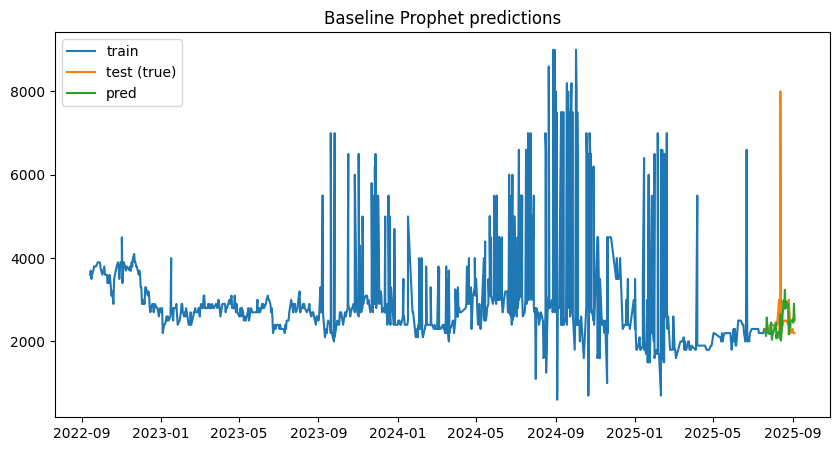

In [447]:
import joblib
import matplotlib.pyplot as plt
# Quick plot
plt.figure(figsize=(10, 5))
plt.plot(train_df["ds"], train_df["y"], label="train")
plt.plot(test_df["ds"], test_df["y"], label="test (true)")
plt.plot(test_df["ds"], y_pred, label="pred")
plt.legend()
plt.title("Baseline Prophet predictions")
plt.show()

In [448]:
# We'll tune a small grid to avoid long runtimes
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.2],
    "seasonality_mode": ["additive", "multiplicative"]
}

best = {"mae": float("inf")}
for cps in param_grid["changepoint_prior_scale"]:
    for mode in param_grid["seasonality_mode"]:
        print(f"Training cps={cps}, mode={mode}")
        m_tmp = fit_prophet(train_df, changepoint_prior=cps, seasonality_mode=mode)
        pred_tmp = m_tmp.predict(future_test)["yhat"].values
        mae_tmp = mean_absolute_error(y_true, pred_tmp)
        print(f" --> MAE: {mae_tmp:.2f}")
        if mae_tmp < best["mae"]:
            best = {"mae": mae_tmp, "cps": cps, "mode": mode, "model": m_tmp}

print("Best params:", best["cps"], best["mode"], "MAE:", best["mae"])

# Use best model for final evaluation
best_model = best["model"]
forecast_test_best = best_model.predict(future_test)
y_pred_best = forecast_test_best["yhat"].values
mae_best = mean_absolute_error(y_true, y_pred_best)
rmse_best = mean_squared_error(y_true, y_pred) ** 0.5
print(f"Final MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}")



23:27:46 - cmdstanpy - INFO - Chain [1] start processing


23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing


Training cps=0.01, mode=additive
 --> MAE: 567.50
Training cps=0.01, mode=multiplicative


23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing


 --> MAE: 543.20
Training cps=0.05, mode=additive
 --> MAE: 487.07
Training cps=0.05, mode=multiplicative


23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing


 --> MAE: 443.57
Training cps=0.2, mode=additive
 --> MAE: 574.58
Training cps=0.2, mode=multiplicative


23:27:46 - cmdstanpy - INFO - Chain [1] done processing


 --> MAE: 559.67
Best params: 0.05 multiplicative MAE: 443.5748604908153
Final MAE: 443.57, RMSE: 1056.65


In [449]:
# # Forecast next 7 days
# # -----------------------
# horizon_days = 7
# last_date = prophet_df["ds"].max()

# # Build future frame: daily frequency for next 7 days
# future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon_days, freq="D")

# # For regressors on future days you must provide values.
# # Options:
# #  1) Use weather forecast from your weather pipeline (recommended).
# #  2) Use persistence (last known value).
# #  3) Use climatology (mean values).
# #
# # Here we show a simple persistence approach (copy last available regressor values).
# last_row = prophet_df.iloc[-1]
# future_regressors = []
# for d in future_dates:
#     row = {
#         "ds": d,
#         "temperature_max": last_row["temperature_max"],
#         "temperature_min": last_row["temperature_min"],
#         "rain_sum": last_row["rain_sum"],
#         "lag_1": last_row["y"],                 # last known price as lag_1
#         "rolling_mean_7": last_row["rolling_mean_7"],
#     }
#     future_regressors.append(row)

# future_df = pd.DataFrame(future_regressors)
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd

# Setup caching and retries
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# API request with start_date and end_date
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 52.52,   # change to your commodity location
    "longitude": 13.41,
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "start_date": "2025-08-20",   # pick dates right after your last Aug entry
    "end_date": "2025-08-27",     # 7 days forecast window
    "timezone": "Asia/Kolkata"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]
daily = response.Daily()

# Convert API response to DataFrame (remove timezone with tz_localize(None))
weather_future = pd.DataFrame({
    "ds": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True)
             .tz_convert("Asia/Kolkata")
             .tz_localize(None),   # removes timezone
        periods=daily.Variables(0).ValuesAsNumpy().size,
        freq="D"
    ),
    "temperature_max": daily.Variables(0).ValuesAsNumpy(),
    "temperature_min": daily.Variables(1).ValuesAsNumpy(),
    "rain_sum": daily.Variables(2).ValuesAsNumpy()
})

print(weather_future.head())

last_row = prophet_df.iloc[-1]
weather_future["rolling_std_7"]=last_row["rolling_std_7"]
weather_future["lag_7"]=last_row["lag_7"]
weather_future["Grade_num"]=0

weather_future["Variety_num"]=0
weather_future["lag_1"] = last_row["y"]
weather_future["rolling_mean_7"] = last_row["rolling_mean_7"]
future_df = weather_future[["ds"] + regressors]
forecast_future = best_model.predict(future_df)
print(forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]])

          ds  temperature_max  temperature_min  rain_sum
0 2025-08-20        25.295500        15.695499       0.0
1 2025-08-21        23.895500        11.445499       0.0
2 2025-08-22        19.395500        11.445499       0.0
3 2025-08-23        16.595499        12.995500       0.2
4 2025-08-24        19.545500         9.545500       0.0
          ds         yhat   yhat_lower   yhat_upper
0 2025-08-20  2732.611549  1296.792638  4147.866753
1 2025-08-21  2466.207951   968.089807  3854.079428
2 2025-08-22  2678.229919  1177.244050  4032.185020
3 2025-08-23  2788.090260  1339.690131  4171.286843
4 2025-08-24  5328.517207  3853.471695  6681.848200
5 2025-08-25  2652.651113  1172.229311  4004.644299
6 2025-08-26  2511.716676  1052.287366  4019.265361
7 2025-08-27  2704.435021  1241.322945  4256.708281


In [450]:
import os
# Predict
forecast_future = best_model.predict(future_df)
print("Forecast next 7 days:")
print(forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]])

# -----------------------
# Save model and forecast
# -----------------------
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/prophet_best_model.joblib")
forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv("next_7_days_forecast.csv", index=False)

print("Done. Model saved to models/prophet_best_model.joblib and forecast saved to next_7_days_forecast.csv")


Forecast next 7 days:
          ds         yhat   yhat_lower   yhat_upper
0 2025-08-20  2732.611549  1349.877107  4210.991748
1 2025-08-21  2466.207951  1106.662909  3920.452848
2 2025-08-22  2678.229919  1260.440584  4177.342370
3 2025-08-23  2788.090260  1391.345625  4141.946679
4 2025-08-24  5328.517207  3940.713523  6755.968576
5 2025-08-25  2652.651113  1128.103102  4072.195633
6 2025-08-26  2511.716676  1019.813010  3886.591371
7 2025-08-27  2704.435021  1209.748451  4003.170490
Done. Model saved to models/prophet_best_model.joblib and forecast saved to next_7_days_forecast.csv


In [451]:
row = commodity_df[commodity_df['Date'] == "2025-08-31"]

print(row)

Empty DataFrame
Columns: [Sl no., District Name, Market Name, Commodity, Variety, Grade, Min_Price, Max_Price, Modal_Price, Date, date, Grade_num, Variety_num]
Index: []


In [245]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd

# Setup caching and retries
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# API request with start_date and end_date
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 52.52,   # change to your commodity location
    "longitude": 13.41,
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "start_date": "2025-08-21",   # pick dates right after your last Aug entry
    "end_date": "2025-08-27",     # 7 days forecast window
    "timezone": "Asia/Kolkata"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]
daily = response.Daily()

# Convert API response to DataFrame
weather_future = pd.DataFrame({
    "ds": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True).tz_convert("Asia/Kolkata"),
        periods=daily.Variables(0).ValuesAsNumpy().size,
        freq="D"
    ),
    "temperature_max": daily.Variables(0).ValuesAsNumpy(),
    "temperature_min": daily.Variables(1).ValuesAsNumpy(),
    "rain_sum": daily.Variables(2).ValuesAsNumpy()
})

print(weather_future.head())


                         ds  temperature_max  temperature_min  rain_sum
0 2025-08-21 00:00:00+05:30        23.895500        11.445499       0.0
1 2025-08-22 00:00:00+05:30        19.395500        11.445499       0.0
2 2025-08-23 00:00:00+05:30        16.595499        12.995500       0.2
3 2025-08-24 00:00:00+05:30        19.545500         9.545500       0.0
4 2025-08-25 00:00:00+05:30        19.845499        11.245500       0.0


In [249]:
last_row = prophet_df.iloc[-1]

weather_future["lag_1"] = last_row["y"]
weather_future["rolling_mean_7"] = last_row["rolling_mean_7"]
weather_future["rolling_std_7"]=last_row["rolling_std_7"]
weather_future["lag_7"]=last_row["lag_7"]
weather_future["Grade_num"]=0

weather_future["ds"] = pd.to_datetime(weather_future["ds"]).dt.date


In [250]:
future_df = weather_future[["ds"] + regressors]
forecast_future = best_model.predict(future_df)
print(forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]])


          ds         yhat   yhat_lower   yhat_upper
0 2025-08-21  2392.124956  1644.209855  3177.920789
1 2025-08-22  2427.021971  1635.590992  3213.577913
2 2025-08-23  2500.677469  1682.148124  3335.115562
3 2025-08-24  2670.027441  1892.262699  3467.890974
4 2025-08-25  2380.465637  1548.677514  3159.902498
5 2025-08-26  2346.844287  1588.054202  3186.613723
6 2025-08-27  2504.561789  1694.769826  3331.673218


14:29:32 - cmdstanpy - INFO - Chain [1] start processing


Train rows: 2618, Test rows: 30
Train until: 2025-02-20, Test starts: 2025-02-21


14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:32 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing
14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:33 - cmdstanpy - INFO - Chain [1] done processing


Best params: cps=0.05, mode=multiplicative (MAE=386.53)
Final Evaluation -> MAE: 386.53, RMSE: 461.01, MAPE: 17.44%


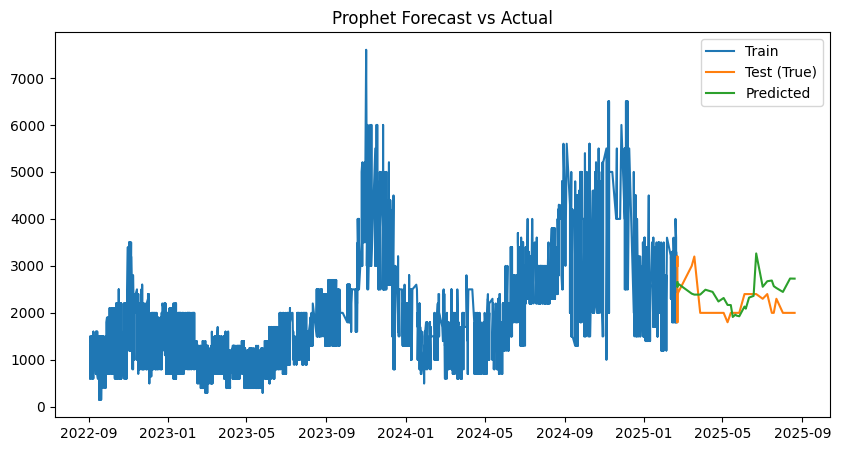

Next 7 Days Forecast:
          ds         yhat   yhat_lower   yhat_upper
0 2025-08-20  2781.484460  1974.303271  3573.190118
1 2025-08-21  2649.811130  1843.234083  3465.595658
2 2025-08-22  2655.361845  1844.712242  3496.284372
3 2025-08-23  2689.717620  1844.235926  3473.435943
4 2025-08-24  3603.473407  2800.537865  4416.442347
5 2025-08-25  2633.935883  1863.326841  3435.604323
6 2025-08-26  2616.870734  1832.365096  3385.576220
7 2025-08-27  2747.173381  2028.524018  3617.550529
✅ Done. Model and forecast saved.


In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os

# -----------------------
# STEP 1: Load & Merge Data
# -----------------------
commodity_df = pd.read_csv("1_commodity_data_delhi.csv")
weather_df = pd.read_csv("weather_data_delhi.csv")

commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

merged_df = pd.merge(commodity_df, weather_df, on="Date", how="left")
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

# -----------------------
# STEP 2: Feature Engineering
# -----------------------
df = merged_df.rename(columns={"Date": "ds", "Modal_Price": "y"})
df["lag_1"] = df["y"].shift(1)
df["lag_7"] = df["y"].shift(7)
df["rolling_mean_7"] = df["y"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df["y"].shift(1).rolling(7).std()
df = df.dropna().reset_index(drop=True)

regressors = ["temperature_max", "temperature_min", "rain_sum", "lag_1", "rolling_mean_7"]
prophet_df = df[["ds", "y"] + regressors].copy()

# -----------------------
# STEP 3: Train/Test Split (DATE-BASED)
# -----------------------
test_days = 30   # keep last 30 days as test set
cutoff_date = prophet_df["ds"].iloc[-test_days]  # first test day

train_df = prophet_df[prophet_df["ds"] < cutoff_date].reset_index(drop=True)
test_df  = prophet_df[prophet_df["ds"] >= cutoff_date].reset_index(drop=True)

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")
print(f"Train until: {train_df['ds'].max().date()}, Test starts: {test_df['ds'].min().date()}")

# -----------------------
# STEP 4: Prophet Training Function
# -----------------------
def fit_prophet(train_df, changepoint_prior=0.05, seasonality_mode="additive"):
    m = Prophet(
        changepoint_prior_scale=changepoint_prior,
        seasonality_mode=seasonality_mode,
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False
    )
    for r in regressors:
        m.add_regressor(r)
    m.fit(train_df)
    return m

# Grid search for best params
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.2],
    "seasonality_mode": ["additive", "multiplicative"]
}

best = {"mae": float("inf")}
future_test = test_df[["ds"] + regressors].copy()
y_true = test_df["y"].values

for cps in param_grid["changepoint_prior_scale"]:
    for mode in param_grid["seasonality_mode"]:
        model_tmp = fit_prophet(train_df, changepoint_prior=cps, seasonality_mode=mode)
        forecast_tmp = model_tmp.predict(future_test)
        y_pred_tmp = forecast_tmp["yhat"].values
        mae_tmp = mean_absolute_error(y_true, y_pred_tmp)
        if mae_tmp < best["mae"]:
            best = {"mae": mae_tmp, "cps": cps, "mode": mode, "model": model_tmp}

best_model = best["model"]
print(f"Best params: cps={best['cps']}, mode={best['mode']} (MAE={best['mae']:.2f})")

# -----------------------
# STEP 5: Model Evaluation
# -----------------------
forecast_test = best_model.predict(future_test)
y_pred = forecast_test["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Final Evaluation -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train_df["ds"], train_df["y"], label="Train")
plt.plot(test_df["ds"], test_df["y"], label="Test (True)")
plt.plot(test_df["ds"], y_pred, label="Predicted")
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()

# -----------------------
# STEP 6: Fetch Weather Forecast & Predict Future Prices
# -----------------------
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 28.61,   # Delhi coordinates
    "longitude": 77.23,
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "start_date": "2025-08-20",
    "end_date": "2025-08-27",
    "timezone": "Asia/Kolkata"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]
daily = response.Daily()

weather_future = pd.DataFrame({
    "ds": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True).tz_convert("Asia/Kolkata").tz_localize(None),
        periods=daily.Variables(0).ValuesAsNumpy().size,
        freq="D"
    ),
    "temperature_max": daily.Variables(0).ValuesAsNumpy(),
    "temperature_min": daily.Variables(1).ValuesAsNumpy(),
    "rain_sum": daily.Variables(2).ValuesAsNumpy()
})

last_row = prophet_df.iloc[-1]
weather_future["lag_1"] = last_row["y"]
weather_future["rolling_mean_7"] = last_row["rolling_mean_7"]

future_df = weather_future[["ds"] + regressors]
forecast_future = best_model.predict(future_df)

print("Next 7 Days Forecast:")
print(forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]])

# -----------------------
# STEP 7: Save Model & Forecast
# -----------------------
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/prophet_best_model.joblib")
forecast_future[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv("next_7_days_forecast.csv", index=False)

print("✅ Done. Model and forecast saved.")


In [100]:
weather_df

,Date,temperature_max,temperature_min,precipitation_sum,rain_sum
0,2024-08-20,31.982500,25.382500,1.500000,1.500000
1,2024-08-21,32.732502,24.782500,6.200000,6.200000
2,2024-08-22,31.232500,24.832499,0.400000,0.400000
3,2024-08-23,31.882500,25.732500,7.900000,7.900000
4,2024-08-24,32.882500,25.232500,15.400001,15.400001
...,...,...,...,...,...
377,2025-09-01,27.032500,23.982500,30.000000,30.000000
378,2025-09-02,29.182499,24.182499,21.000006,21.000006
379,2025-09-03,31.682499,23.882500,10.100000,10.100000
380,2025-09-04,31.232500,25.632500,5.200000,5.200000


In [12]:
commodity_df['date'] = commodity_df['Date'].dt.date

In [59]:
#using prophet to predict future prices
import pandas as pd
from prophet import Prophet

# Load your CSVs
commodity_df = pd.read_csv("commodity_data_delhi.csv")  # your Apple price data
weather_df = pd.read_csv("weather_data_delhi.csv")      # weather features

# Convert dates to datetime
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Keep only relevant columns
commodity_df = commodity_df[['Date', 'Modal_Price']].rename(columns={'Date':'ds', 'Modal_Price':'y'})

# Select weather features as regressors
weather_features = ['temperature_max', 'temperature_min', 'rain_sum']

# Merge commodity + weather on date
df = pd.merge(commodity_df, weather_df[['Date'] + weather_features], left_on='ds', right_on='Date', how='left')
df.drop('Date', axis=1, inplace=True)

# Check the dataframe
print(df.head())


          ds      y  temperature_max  temperature_min  rain_sum
0 2024-12-19  10000          23.0325         9.882501       0.0
1 2025-06-02   5000          35.1325        26.832499       0.2
2 2024-12-13  10000          20.7325         8.532500       0.0
3 2024-12-12   9000          20.5325         9.132501       0.0
4 2024-12-18   9000          21.1325         7.682500       0.0


In [55]:
weather_df

,Date,temperature_max,temperature_min,precipitation_sum,rain_sum
0,2024-08-20,31.982500,25.382500,1.500000,1.500000
1,2024-08-21,32.732502,24.782500,6.200000,6.200000
2,2024-08-22,31.232500,24.832499,0.400000,0.400000
3,2024-08-23,31.882500,25.732500,7.900000,7.900000
4,2024-08-24,32.882500,25.232500,15.400001,15.400001
...,...,...,...,...,...
377,2025-09-01,27.032500,23.982500,30.000000,30.000000
378,2025-09-02,29.182499,24.182499,21.000006,21.000006
379,2025-09-03,31.682499,23.882500,10.100000,10.100000
380,2025-09-04,31.232500,25.632500,5.200000,5.200000


In [88]:
commodity_df

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Date,date
0,1,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,800,14000,10000,2024-12-19,2024-12-19
1,2,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,4000,6000,5000,2025-06-02,2025-06-02
2,3,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,12000,10000,2024-12-13,2024-12-13
3,4,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,13000,9000,2024-12-12,2024-12-12
4,5,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,13000,9000,2024-12-18,2024-12-18
...,...,...,...,...,...,...,...,...,...,...,...
228,229,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-08-05,2025-08-05
229,230,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-08-06,2025-08-06
230,231,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-05-15,2025-05-15
231,232,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-05-26,2025-05-26


In [95]:
df

,ds,y,temperature_max,temperature_min,rain_sum,lag_1,lag_7,rolling_mean_7,rolling_std_7
0,2024-12-19,10000,23.032500,9.882501,0.000000,NaN,NaN,NaN,NaN
1,2025-06-02,5000,35.132500,26.832499,0.200000,10000.0,NaN,NaN,NaN
2,2024-12-13,10000,20.732500,8.532500,0.000000,5000.0,NaN,NaN,NaN
3,2024-12-12,9000,20.532500,9.132501,0.000000,10000.0,NaN,NaN,NaN
4,2024-12-18,9000,21.132500,7.682500,0.000000,9000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
228,2025-08-05,16000,32.182503,26.432499,0.700000,16000.0,15000.0,15000.000000,816.496581
229,2025-08-06,16000,34.132500,26.232500,0.000000,16000.0,15000.0,15142.857143,899.735411
230,2025-05-15,16000,42.832500,28.382500,0.000000,16000.0,15000.0,15285.714286,951.189731
231,2025-05-26,16000,36.282500,26.432499,0.000000,16000.0,15000.0,15428.571429,975.900073


In [62]:
model = Prophet()
for feature in weather_features:
    model.add_regressor(feature)

model.fit(df)


18:23:01 - cmdstanpy - INFO - Chain [1] start processing
18:23:02 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
future = model.make_future_dataframe(periods=30, freq='D')

# Add regressors (must align with future dates)
# If you don’t have real future weather, you can use averages or scenario assumptions
for feature in weather_features:
    future[feature] = df[feature].mean()   # simple assumption: use average values


In [66]:
forecast = model.predict(future)
forecast.to_csv("forecasted_prices.csv", index=False)


In [94]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10)


,ds,yhat,yhat_lower,yhat_upper
0,2024-08-29,10533.415840,9087.077003,11929.111412
1,2024-08-30,10451.446194,8958.223289,11877.930983
2,2024-08-31,10294.779147,8765.030297,11803.001803
3,2024-09-02,9970.905932,8402.749807,11599.618978
4,2024-09-03,10657.087970,9212.144743,12212.032930
5,2024-09-04,10409.049883,9020.509338,11919.199760
6,2024-09-05,10614.057681,9083.316863,12111.834177
7,2024-09-06,10532.088035,9095.436770,12026.078360
8,2024-09-09,10051.547773,8598.756619,11589.737660
9,2024-09-10,10737.729811,9379.272682,12181.912861


In [92]:
row = commodity_df[commodity_df['Date'] == "2024-09-10"]

print(row)

    Sl no. District Name                  Market Name Commodity Variety  \
18      19     Bangalore  Binny Mill (F&V), Bangalore     Apple   Apple   

    Grade  Min_Price  Max_Price  Modal_Price       Date        date  
18  Large       8000      12000        10000 2024-09-10  2024-09-10  


In [91]:
commodity_df

,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min_Price,Max_Price,Modal_Price,Date,date
0,1,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,800,14000,10000,2024-12-19,2024-12-19
1,2,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,4000,6000,5000,2025-06-02,2025-06-02
2,3,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,12000,10000,2024-12-13,2024-12-13
3,4,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,13000,9000,2024-12-12,2024-12-12
4,5,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,7000,13000,9000,2024-12-18,2024-12-18
...,...,...,...,...,...,...,...,...,...,...,...
228,229,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-08-05,2025-08-05
229,230,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-08-06,2025-08-06
230,231,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-05-15,2025-05-15
231,232,Bangalore,"Binny Mill (F&V), Bangalore",Apple,Apple,Large,11000,18000,16000,2025-05-26,2025-05-26


In [75]:
df['lag_1'] = df['y'].shift(1)         # yesterday's price
df['lag_7'] = df['y'].shift(7)         # last week's price
df['rolling_mean_7'] = df['y'].rolling(7).mean()
df['rolling_std_7'] = df['y'].rolling(7).std()


In [82]:
from xgboost import XGBRegressor

# Train Prophet first
prophet = Prophet()
prophet.add_regressor("temperature_max")
prophet.fit(df)

forecast = prophet.predict(df)
df["residual"] = df["y"] - forecast["yhat"]

# Train ML on residuals
X = df[["temperature_max", "temperature_min", "rain_sum", "lag_1", "rolling_mean_7"]]
y = df["residual"]
xgb = XGBRegressor()
xgb.fit(X.fillna(0), y.fillna(0))


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/nc25880-EediMounikaSravanthi/Documents/commodity_price_market_intelligence/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <E8D72161-CCD1-3423-9388-36D4CA0A7524> /Users/nc25880-EediMounikaSravanthi/Documents/commodity_price_market_intelligence/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)"]


In [271]:
from typing import List

def min_operations_to_permutation(arr: List[int]) -> int:
    n = len(arr)
    arr.sort()
    target = list(range(1, n+1))
    operations = 0
    for a, b in zip(arr, target):
        operations += abs(a - b)
    return operations

if __name__ == "__main__":
    line = input()
    k = [int(i) for i in line.strip().split()]
    print(min_operations_to_permutation(k))

4


In [273]:
from typing import List

def squared_sum(arr: List[int]) -> int:
    # Kadane’s for max subarray sum
    max_ending_here = max_so_far = arr[0]
    min_ending_here = min_so_far = arr[0]

    for x in arr[1:]:
        max_ending_here = max(x, max_ending_here + x)
        max_so_far = max(max_so_far, max_ending_here)

        min_ending_here = min(x, min_ending_here + x)
        min_so_far = min(min_so_far, min_ending_here)

    # Max cost will be square of max abs sum
    return max(max_so_far**2, min_so_far**2)


if __name__ == "__main__":
    line = input()
    arr = [int(i) for i in line.strip().split()]
    print(squared_sum(arr))

36


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# 🔹 Fetch data from Agmarknet
# ----------------------------
def fetch_agmarknet_data(commodity_code, state_code, district_id, market_id, date_from, date_to,
                         commodity_name="", state_name="", district_name="", market_name="--Select--"):
    url = "https://agmarknet.gov.in/SearchCmmMkt.aspx"
    params = {
        "Tx_Commodity": commodity_code,
        "Tx_State": state_code,
        "Tx_District": district_id,
        "Tx_Market": market_id,
        "DateFrom": date_from,
        "DateTo": date_to,
        "Fr_Date": date_from,
        "To_Date": date_to,
        "Tx_Trend": "0",
        "Tx_CommodityHead": commodity_name,
        "Tx_StateHead": state_name,
        "Tx_DistrictHead": district_name,
        "Tx_MarketHead": market_name
    }

    res = requests.get(url, params=params)
    res.raise_for_status()

    soup = BeautifulSoup(res.text, "html.parser")
    table = soup.find("table", {"id": "cphBody_GridPriceData"})
    
    if not table:
        return {"error": "No data table found. Check your parameters."}

    data = []
    headers = [th.get_text(strip=True) for th in table.find_all("th")]

    for row in table.find_all("tr")[1:]:  # skip header
        cols = [c.get_text(strip=True) for c in row.find_all("td")]
        if cols:
            data.append(dict(zip(headers, cols)))

    return data

# ----------------------------
# 🔹 Date range (last 3 years, ending 10 days ago)
# ----------------------------
end_date = datetime.now().date() - timedelta(days=10)
start_date = end_date - timedelta(days=1095)

date_from = start_date.strftime("%d-%b-%Y")
date_to = end_date.strftime("%d-%b-%Y")

print(f"Fetching data from {date_from} to {date_to}...")

data = fetch_agmarknet_data(
    commodity_code="90",      # Example: Apple
    state_code="KK",          # Karnataka
    district_id="1",          # Bangalore
    market_id="0",            # All markets
    date_from=date_from,
    date_to=date_to,
    commodity_name="Green Banana",
    state_name="Karnataka",
    district_name="Bangalore"
)

# ----------------------------
# 🔹 Save & clean the dataset
# ----------------------------
if isinstance(data, list) and data:
    filename = "agmarknet_data_new.csv"
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)
    print(f"✅ Data saved to {filename}")

    

In [1]:
import pandas as pd 
df = pd.read_csv("final_merged_data.csv")
len(df)

2509

In [3]:
df = df.sort_values("Date").reset_index(drop=True)
    
    # Rename for Prophet
df = df.rename(columns={"Date": "ds", "Modal_Price": "y"})

In [6]:
df.columns

Index(['Arrivals (Tonnes)', 'Min_Price', 'Max_Price', 'y', 'ds',
       'temperature_max', 'temperature_min', 'precipitation_sum', 'rain_sum',
       'Market_ID', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_30', 'price_momentum_7',
       'price_volatility_7'],
      dtype='object')

In [ ]:
df["lag_1"] = df["y"].shift(1)
df["lag_7"] = df["y"].shift(7)
df["lag_30"] = df["y"].shift(30)
    
    # Rolling statistics
df["rolling_mean_7"] = df["y"].shift(1).rolling(window=7, min_periods=3).mean()
df["rolling_std_7"] = df["y"].shift(1).rolling(window=7, min_periods=3).std()
df["rolling_mean_30"] = df["y"].shift(1).rolling(window=30, min_periods=10).mean()
    
    # Price momentum features
df["price_momentum_7"] = (df["y"] - df["rolling_mean_7"]) / df["rolling_mean_7"]
df["price_volatility_7"] = df["rolling_std_7"] / df["rolling_mean_7"]
    
    # Seasonal features
df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
df["month"] = df["ds"].dt.month
df["quarter"] = df["ds"].dt.quarter
df["day_of_year"] = df["ds"].dt.dayofyear
df['temperature_range'] =df['temperature_max'] - df['temperature_min']
df['temperature_avg'] = (df['temperature_max'] + df['temperature_min']) / 2
    
    # Weather interaction features
df["temp_rain_interaction"] = df["temperature_avg"] * df["rain_sum"]
    
    # Drop rows with NaN from feature creation
df = df.dropna().reset_index(drop=True)
    

In [11]:
df
    

,Arrivals (Tonnes),Min_Price,Max_Price,y,ds,temperature_max,temperature_min,precipitation_sum,rain_sum,Market_ID,...,rolling_std_7,rolling_mean_30,price_momentum_7,price_volatility_7,month,quarter,day_of_year,temperature_range,temperature_avg,temp_rain_interaction
0,62.0,1200,1500,1300,2015-11-02,26.437000,19.587000,16.300001,16.300001,1,...,382.348632,1380.000000,-0.165138,0.245545,11,4,306,6.850000,23.012000,375.095623
1,86.0,1500,2000,1800,2015-11-03,26.237000,19.387000,22.599998,22.599998,1,...,262.769136,1400.000000,0.260000,0.183938,11,4,307,6.850000,22.812000,515.551154
2,52.0,2000,2500,2300,2015-11-04,26.337000,18.237000,0.000000,0.000000,1,...,262.769136,1436.666667,0.610000,0.183938,11,4,308,8.100000,22.287000,0.000000
3,53.0,2000,2400,2200,2015-11-05,26.987000,17.187000,0.000000,0.000000,1,...,397.611919,1493.333333,0.387387,0.250746,11,4,309,9.800000,22.087000,0.000000
4,54.0,2600,3000,2800,2015-11-06,26.786999,19.036999,0.000000,0.000000,1,...,457.737708,1543.333333,0.704348,0.278623,11,4,310,7.750000,22.911999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,99.0,1000,1200,1100,2025-09-10,26.211000,19.211000,0.400000,0.400000,1,...,657.918797,2893.333333,-0.465278,0.319822,9,3,253,7.000000,22.711000,9.084400
2475,83.0,1000,1200,1100,2025-09-11,27.161001,19.561000,0.400000,0.400000,1,...,694.879229,2840.000000,-0.403101,0.377066,9,3,254,7.600001,23.361000,9.344400
2476,151.0,1000,1200,1100,2025-09-12,28.011000,18.811000,1.200000,1.200000,1,...,694.879229,2786.666667,-0.336207,0.419324,9,3,255,9.200000,23.411000,28.093200
2477,212.0,1000,1200,1100,2025-09-15,27.761000,18.761000,0.000000,0.000000,1,...,634.335047,2740.000000,-0.252427,0.431101,9,3,258,9.000000,23.261000,0.000000


In [12]:
print("\n5. Training enhanced model...")

# Define regressors
regressors = [
    "temperature_max", "temperature_min", "rain_sum", "temperature_range", "temperature_avg",
    "lag_1", "lag_7", "rolling_mean_7", "rolling_std_7", "rolling_mean_30",
    "price_momentum_7", "price_volatility_7",
    "Grade_num", "Variety_num", "month", "quarter",
    "temp_rain_interaction", "Arrivals (Tonnes)"
]

prophet_df = df[["ds", "y"] + regressors].copy()

# Train/test split
test_days = 60
cutoff_date = prophet_df["ds"].iloc[-test_days]

train_df = prophet_df[prophet_df["ds"] < cutoff_date].reset_index(drop=True)
test_df = prophet_df[prophet_df["ds"] >= cutoff_date].reset_index(drop=True)

print(f"Training data: {len(train_df)} rows")
print(f"Test data: {len(test_df)} rows")

# Hyperparameter tuning
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2],
    "seasonality_prior_scale": [1.0, 10.0, 100.0],
    "seasonality_mode": ["additive", "multiplicative"]
}

best_params = {"mae": float("inf")}

for cps in param_grid["changepoint_prior_scale"]:
    for sps in param_grid["seasonality_prior_scale"]:
        for mode in param_grid["seasonality_mode"]:
            model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode=mode,
                weekly_seasonality=True,
                yearly_seasonality=True,
                daily_seasonality=False
            )
            
            for reg in regressors:
                model.add_regressor(reg)
            
            try:
                model.fit(train_df)
                
                test_future = test_df[["ds"] + regressors].copy()
                forecast = model.predict(test_future)
                mae = mean_absolute_error(test_df["y"], forecast["yhat"])
                
                if mae < best_params["mae"]:
                    best_params = {
                        "mae": mae,
                        "cps": cps,
                        "sps": sps,
                        "mode": mode,
                        "model": model
                    }
                print(f"CPS={cps}, SPS={sps}, Mode={mode} -> MAE: {mae:.2f}")
            except Exception as e:
                print(f"Error with CPS={cps}, SPS={sps}, Mode={mode}: {e}")
                continue

# Best model
best_model = best_params["model"]

# Final evaluation
test_future = test_df[["ds"] + regressors].copy()
final_forecast = best_model.predict(test_future)

mae = mean_absolute_error(test_df["y"], final_forecast["yhat"])
rmse = np.sqrt(mean_squared_error(test_df["y"], final_forecast["yhat"]))
mape = np.mean(np.abs((test_df["y"] - final_forecast["yhat"]) / test_df["y"])) * 100

print(f"\nBest Model Performance:")
print(f"Parameters: {best_params}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



5. Training enhanced model...


KeyError: "['Grade_num', 'Variety_num'] not in index"

In [36]:
#14/09/2025 11:00 PM
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import requests_cache
from retry_requests import retry
import openmeteo_requests
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [13]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup Open-Meteo API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Set daily weather variables
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 12.9716,
    "longitude": 77.5946,
    "start_date": "2015-09-16",
    "end_date": "2025-09-16",
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum"],
    "timezone": "auto"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data
daily = response.Daily()
daily_temperature_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation = daily.Variables(2).ValuesAsNumpy()
daily_rain = daily.Variables(3).ValuesAsNumpy()

# ✅ Build correct date range
dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)

daily_data = {
    "Date": dates.tz_localize(None),  # drop UTC timezone
    "temperature_max": daily_temperature_max,
    "temperature_min": daily_temperature_min,
    "precipitation_sum": daily_precipitation,
    "rain_sum": daily_rain
}

daily_dataframe = pd.DataFrame(data=daily_data)

# Handle missing rain values → replace NaN with 0
daily_dataframe["rain_sum"] = daily_dataframe["rain_sum"].fillna(0)

daily_dataframe["Date"] = pd.to_datetime(daily_dataframe["Date"]).dt.date

print(daily_dataframe.head())
print(daily_dataframe.tail())


daily_dataframe.head()

Coordinates: 12.970123291015625°N 77.56363677978516°E
Elevation: 910.0 m asl
Timezone difference to GMT+0: 19800s
         Date  temperature_max  temperature_min  precipitation_sum  rain_sum
0  2015-09-15        25.786999        20.286999                2.6       2.6
1  2015-09-16        27.286999        19.837000                0.0       0.0
2  2015-09-17        26.937000        18.636999                0.0       0.0
3  2015-09-18        27.087000        19.737000                0.5       0.5
4  2015-09-19        26.587000        19.437000                2.1       2.1
            Date  temperature_max  temperature_min  precipitation_sum  \
3649  2025-09-11        27.161001        19.561001                0.4   
3650  2025-09-12        28.011000        18.811001                1.2   
3651  2025-09-13        27.761000        18.761000                0.0   
3652  2025-09-14              NaN              NaN                NaN   
3653  2025-09-15              NaN              NaN         

,Date,temperature_max,temperature_min,precipitation_sum,rain_sum
0,2015-09-15,25.786999,20.286999,2.6,2.6
1,2015-09-16,27.286999,19.837000,0.0,0.0
2,2015-09-17,26.937000,18.636999,0.0,0.0
3,2015-09-18,27.087000,19.737000,0.5,0.5
4,2015-09-19,26.587000,19.437000,2.1,2.1


In [15]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import urllib.parse

# ----------------------------
# 🔹 Fetch data from Agmarknet (returns DataFrame)
# ----------------------------
def fetch_agmarknet_data(commodity_code, state_code, district_id, market_id, date_from, date_to,
                         data_type="both", commodity_name="", state_name="", district_name="", market_name=""):
    """
    Fetch data from Agmarknet and return as a Pandas DataFrame.
    
    data_type options:
    - "price" or 0: Price only
    - "arrival" or 1: Arrival only  
    - "both" or 2: Both price and arrival (default)
    """
    
    # Convert data_type to correct Tx_Trend param
    if data_type == "price":
        trend_param = "0"
    elif data_type == "arrival": 
        trend_param = "1"
    else:  
        trend_param = "2"
    
    base_url = "https://agmarknet.gov.in/SearchCmmMkt.aspx"
    
    params = {
        "Tx_Commodity": commodity_code,
        "Tx_State": state_code,
        "Tx_District": district_id,
        "Tx_Market": market_id,
        "DateFrom": date_from,
        "DateTo": date_to,
        "Fr_Date": date_from,
        "To_Date": date_to,
        "Tx_Trend": trend_param,
        "Tx_CommodityHead": commodity_name,
        "Tx_StateHead": state_name,
        "Tx_DistrictHead": district_name,
        "Tx_MarketHead": market_name
    }
    
    url = f"{base_url}?" + urllib.parse.urlencode(params)
    print(f"🔍 Requesting URL: {url}")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }

    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
        print(f"✅ Response status: {response.status_code}")
        
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Try known table IDs
        table = None
        possible_table_ids = [
            "cphBody_GridPriceData", 
            "GridPriceData",
            "gvPrice", 
            "gvPriceData"
        ]
        
        for table_id in possible_table_ids:
            table = soup.find("table", {"id": table_id})
            if table:
                print(f"🔍 Found table with ID: {table_id}")
                break
        
        if not table:
            all_tables = soup.find_all("table")
            print(f"⚠️ No table found with expected IDs. Found {len(all_tables)} total tables")
            for i, t in enumerate(all_tables):
                rows = t.find_all("tr")
                if len(rows) > 1:
                    print(f"🔍 Using table {i} with {len(rows)} rows")
                    table = t
                    break
        
        if not table:
            return pd.DataFrame()  # return empty dataframe

        # Extract headers
        header_row = table.find("tr")
        headers = [th.get_text(strip=True) for th in header_row.find_all(["th", "td"])]
        print(f"📊 Columns: {headers}")
        
        # Extract rows
        data = []
        rows = table.find_all("tr")[1:]
        for row in rows:
            cols = [td.get_text(strip=True) for td in row.find_all("td")]
            if cols and len(cols) == len(headers):
                data.append(dict(zip(headers, cols)))
        
        print(f"✅ Extracted {len(data)} rows")
        
        return pd.DataFrame(data)

    except requests.RequestException as e:
        print(f"❌ Request failed: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Parsing failed: {e}")
        return pd.DataFrame()


# ----------------------------
# 🔹 Example usage
# ----------------------------
if __name__ == "__main__":
    date_from = "16-Sep-2015"
    date_to = "16-Sep-2025"
    
    commodity_df = fetch_agmarknet_data(
        commodity_code="78",
        state_code="KK", 
        district_id="1",
        market_id="108",
        date_from=date_from,
        date_to=date_to,
        data_type="both",  
        commodity_name="Onion",
        state_name="Karnataka",
        district_name="Bangalore", 
        market_name="Binny Mill (F&V), Bangalore"
    )
    
    if not df.empty:
        print(df.head())
        print(f"✅ DataFrame shape: {df.shape}")
    else:
        print("❌ No data extracted")


🔍 Requesting URL: https://agmarknet.gov.in/SearchCmmMkt.aspx?Tx_Commodity=78&Tx_State=KK&Tx_District=1&Tx_Market=108&DateFrom=16-Sep-2015&DateTo=16-Sep-2025&Fr_Date=16-Sep-2015&To_Date=16-Sep-2025&Tx_Trend=2&Tx_CommodityHead=Onion&Tx_StateHead=Karnataka&Tx_DistrictHead=Bangalore&Tx_MarketHead=Binny+Mill+%28F%26V%29%2C+Bangalore
✅ Response status: 200
⚠️ No table found with expected IDs. Found 1 total tables
🔍 Using table 0 with 2514 rows
📊 Columns: ['State Name', 'District Name', 'Market Name', 'Variety', 'Group', 'Arrivals (Tonnes)', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)', 'Reported Date', 'Grade']
✅ Extracted 2513 rows
  State Name District Name                  Market Name Variety       Group  \
0  Karnataka     Bangalore  Binny Mill (F&V), Bangalore  Tomato  Vegetables   
1  Karnataka     Bangalore  Binny Mill (F&V), Bangalore  Tomato  Vegetables   
2  Karnataka     Bangalore  Binny Mill (F&V), Bangalore  Tomato  Vegetables   
3  Karnataka

In [23]:

commodity_df.rename(columns={
        "Reported Date": "Date",
        "Min Price (Rs./Quintal)": "Min_Price",
        "Max Price (Rs./Quintal)": "Max_Price",
        "Modal Price (Rs./Quintal)": "Modal_Price"
    }, inplace=True)

commodity_df = commodity_df.iloc[:-2].reset_index(drop=True)

# Convert Date column to datetime and format it as YYYY-MM-DD (or any format you want)
commodity_df["Date"] = pd.to_datetime(commodity_df["Date"], errors="coerce").dt.strftime("%Y-%m-%d")

# Final cleaned DataFrame

commodity_df=commodity_df.sort_values("Date").reset_index(drop=True)
unique_grades = commodity_df["Grade"].unique()
grade_mapping = {grade: idx for idx, grade in enumerate(unique_grades)}
commodity_df["Grade_num"] = commodity_df["Grade"].map(grade_mapping)

print("Dynamic grade mapping:", grade_mapping)

    # ----------------------------
    # 🔹 Encode Variety dynamically
    # ----------------------------
unique_varieties = commodity_df["Variety"].unique()
variety_mapping = {var: idx for idx, var in enumerate(unique_varieties)}
commodity_df["Variety_num"] = commodity_df["Variety"].map(variety_mapping)

commodity_df.tail()

Dynamic grade mapping: {'FAQ': 0, 'Ref grade-1': 1, 'Ref grade-2': 2, 'Local': 3}


,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min_Price,Max_Price,Modal_Price,Date,Grade,Grade_num,Variety_num
2500,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,152.00,1000,1200,1100,2025-09-08,Local,3,0
2501,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,114.00,1000,1200,1100,2025-09-09,Local,3,0
2502,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,99.00,1000,1200,1100,2025-09-10,Local,3,0
2503,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,83.00,1000,1200,1100,2025-09-11,Local,3,0
2504,Karnataka,Bangalore,"Binny Mill (F&V), Bangalore",Tomato,Vegetables,151.00,1000,1200,1100,2025-09-12,Local,3,0


In [27]:
commodity_df['Date'] = pd.to_datetime(commodity_df['Date'])
daily_dataframe['Date'] = pd.to_datetime(daily_dataframe['Date']) 
#Merge on Date
merged_df = pd.merge(
    commodity_df,
    daily_dataframe,
    on="Date",   # common columne
    how="left"   # keep all commodity rows, add weather if date matches
)


# Load your existing merged data
# merged_df = pd.read_csv("merged_commodity_weather.csv")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values("Date").reset_index(drop=True)
unique_markets = merged_df["Market Name"].unique()
print("Unique Market Names:", unique_markets)

# Create mapping {market_name: id}
market_mapping = {name: idx for idx, name in enumerate(unique_markets, start=1)}
print("\nMapping:", market_mapping)

# Map to integer column
merged_df["Market_ID"] = merged_df["Market Name"].map(market_mapping)

merged_df["Arrivals (Tonnes)"] = pd.to_numeric(merged_df["Arrivals (Tonnes)"], errors='coerce')
df = merged_df.drop(
    columns=["State Name", "District Name", "Market Name", "Variety", "Group", "Grade"]
)

print(df.head())
print(df.dtypes)




Unique Market Names: ['Binny Mill (F&V), Bangalore']

Mapping: {'Binny Mill (F&V), Bangalore': 1}
   Arrivals (Tonnes) Min_Price Max_Price Modal_Price       Date  Grade_num  \
0               62.0       500       700         600 2015-09-19          0   
1               60.0       600       900         700 2015-09-21          0   
2               60.0       700       900         800 2015-09-22          0   
3               59.0       800      1200        1000 2015-09-23          0   
4               56.0      1000      1400        1200 2015-09-24          0   

   Variety_num  temperature_max  temperature_min  precipitation_sum  \
0            0        26.587000        19.437000           2.100000   
1            0        28.386999        17.437000           0.000000   
2            0        28.337000        17.837000           0.000000   
3            0        28.937000        20.386999          13.300000   
4            0        28.237000        18.987000          15.599999   

    ra

In [28]:
df = df.sort_values("Date").reset_index(drop=True)
    
    # Rename for Prophet
df = df.rename(columns={"Date": "ds", "Modal_Price": "y"})

In [31]:
df["ds"] = pd.to_datetime(df["ds"], errors="coerce")   # Date column
df["y"] = pd.to_numeric(df["y"], errors="coerce")  
df["lag_1"] = df["y"].shift(1)
df["lag_7"] = df["y"].shift(7)

df["lag_30"] = df["y"].shift(30)
    
    # Rolling statistics
df["rolling_mean_7"] = df["y"].shift(1).rolling(window=7, min_periods=3).mean()
df["rolling_std_7"] = df["y"].shift(1).rolling(window=7, min_periods=3).std()
df["rolling_mean_30"] = df["y"].shift(1).rolling(window=30, min_periods=10).mean()
    
    # Price momentum features
df["price_momentum_7"] = (df["y"] - df["rolling_mean_7"]) / df["rolling_mean_7"]
df["price_volatility_7"] = df["rolling_std_7"] / df["rolling_mean_7"]
    
    # Seasonal features
df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
df["month"] = df["ds"].dt.month
df["quarter"] = df["ds"].dt.quarter
df["day_of_year"] = df["ds"].dt.dayofyear
df['temperature_range'] =df['temperature_max'] - df['temperature_min']
df['temperature_avg'] = (df['temperature_max'] + df['temperature_min']) / 2
    
    # Weather interaction features
df["temp_rain_interaction"] = df["temperature_avg"] * df["rain_sum"]
    
    # Drop rows with NaN from feature creation
df = df.dropna().reset_index(drop=True)
    

In [33]:
df.columns

Index(['Arrivals (Tonnes)', 'Min_Price', 'Max_Price', 'y', 'ds', 'Grade_num',
       'Variety_num', 'temperature_max', 'temperature_min',
       'precipitation_sum', 'rain_sum', 'Market_ID', 'lag_1', 'lag_7',
       'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30',
       'price_momentum_7', 'price_volatility_7', 'month', 'quarter',
       'day_of_year', 'temperature_range', 'temperature_avg',
       'temp_rain_interaction'],
      dtype='object')

In [ ]:
import prophet
print("\n5. Training enhanced model...")

# Define regressors
regressors = [
    "temperature_max", "temperature_min", "rain_sum", "temperature_range", "temperature_avg",
    "lag_1", "lag_7", "rolling_mean_7", "rolling_std_7", "rolling_mean_30",
    "price_momentum_7", "price_volatility_7",
    "Grade_num", "Variety_num", "month", "quarter",
    "temp_rain_interaction", "Arrivals (Tonnes)"
]

prophet_df = df[["ds", "y"] + regressors].copy()

# Train/test split
test_days = 500
cutoff_date = prophet_df["ds"].iloc[-test_days]

train_df = prophet_df[prophet_df["ds"] < cutoff_date].reset_index(drop=True)
test_df = prophet_df[prophet_df["ds"] >= cutoff_date].reset_index(drop=True)

print(f"Training data: {len(train_df)} rows")
print(f"Test data: {len(test_df)} rows")

# Hyperparameter tuning
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2],
    "seasonality_prior_scale": [1.0, 10.0, 100.0],
    "seasonality_mode": ["additive", "multiplicative"]
}

best_params = {"mae": float("inf")}

for cps in param_grid["changepoint_prior_scale"]:
    for sps in param_grid["seasonality_prior_scale"]:
        for mode in param_grid["seasonality_mode"]:
            model = Prophet(
                changepoint_prior_scale=cps,
                seasonality_prior_scale=sps,
                seasonality_mode=mode,
                weekly_seasonality=True,
                yearly_seasonality=True,
                daily_seasonality=False
            )
            
            for reg in regressors:
                model.add_regressor(reg)
            
            try:
                model.fit(train_df)
                
                test_future = test_df[["ds"] + regressors].copy()
                forecast = model.predict(test_future)
                mae = mean_absolute_error(test_df["y"], forecast["yhat"])
                
                if mae < best_params["mae"]:
                    best_params = {
                        "mae": mae,
                        "cps": cps,
                        "sps": sps,
                        "mode": mode,
                        "model": model
                    }
                print(f"CPS={cps}, SPS={sps}, Mode={mode} -> MAE: {mae:.2f}")
            except Exception as e:
                print(f"Error with CPS={cps}, SPS={sps}, Mode={mode}: {e}")
                continue

# Best model
best_model = best_params["model"]

# Final evaluation
test_future = test_df[["ds"] + regressors].copy()
final_forecast = best_model.predict(test_future)

mae = mean_absolute_error(test_df["y"], final_forecast["yhat"])
rmse = np.sqrt(mean_squared_error(test_df["y"], final_forecast["yhat"]))
mape = np.mean(np.abs((test_df["y"] - final_forecast["yhat"]) / test_df["y"])) * 100

print(round(score,2)*100)
print(f"\nBest Model Performance:")
print(f"Parameters: {best_params}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


21:48:19 - cmdstanpy - INFO - Chain [1] start processing



5. Training enhanced model...
Training data: 1975 rows
Test data: 500 rows


21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:19 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=1.0, Mode=additive -> MAE: 144.27


21:48:19 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=1.0, Mode=multiplicative -> MAE: 148.53


21:48:20 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=10.0, Mode=additive -> MAE: 144.18


21:48:20 - cmdstanpy - INFO - Chain [1] done processing
21:48:20 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=10.0, Mode=multiplicative -> MAE: 148.61


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=100.0, Mode=additive -> MAE: 144.18


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.01, SPS=100.0, Mode=multiplicative -> MAE: 148.57


21:48:21 - cmdstanpy - INFO - Chain [1] done processing
21:48:21 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=1.0, Mode=additive -> MAE: 144.42


21:48:22 - cmdstanpy - INFO - Chain [1] done processing
21:48:22 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=1.0, Mode=multiplicative -> MAE: 146.90


21:48:22 - cmdstanpy - INFO - Chain [1] done processing
21:48:22 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=10.0, Mode=additive -> MAE: 144.36


21:48:23 - cmdstanpy - INFO - Chain [1] done processing
21:48:23 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=10.0, Mode=multiplicative -> MAE: 147.90


21:48:23 - cmdstanpy - INFO - Chain [1] done processing
21:48:23 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=100.0, Mode=additive -> MAE: 144.40


21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.05, SPS=100.0, Mode=multiplicative -> MAE: 147.06


21:48:24 - cmdstanpy - INFO - Chain [1] done processing
21:48:24 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=1.0, Mode=additive -> MAE: 144.71


21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=1.0, Mode=multiplicative -> MAE: 153.21


21:48:25 - cmdstanpy - INFO - Chain [1] done processing
21:48:25 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=10.0, Mode=additive -> MAE: 144.87


21:48:26 - cmdstanpy - INFO - Chain [1] done processing
21:48:27 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=10.0, Mode=multiplicative -> MAE: 160.49


21:48:27 - cmdstanpy - INFO - Chain [1] done processing
21:48:27 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=100.0, Mode=additive -> MAE: 144.78


21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.1, SPS=100.0, Mode=multiplicative -> MAE: 153.71


21:48:28 - cmdstanpy - INFO - Chain [1] done processing
21:48:28 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.2, SPS=1.0, Mode=additive -> MAE: 144.64


21:48:29 - cmdstanpy - INFO - Chain [1] done processing
21:48:29 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.2, SPS=1.0, Mode=multiplicative -> MAE: 163.82


21:48:30 - cmdstanpy - INFO - Chain [1] done processing
21:48:30 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.2, SPS=10.0, Mode=additive -> MAE: 144.77


21:48:31 - cmdstanpy - INFO - Chain [1] done processing
21:48:31 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.2, SPS=10.0, Mode=multiplicative -> MAE: 167.72


21:48:32 - cmdstanpy - INFO - Chain [1] done processing
21:48:32 - cmdstanpy - INFO - Chain [1] start processing


CPS=0.2, SPS=100.0, Mode=additive -> MAE: 144.69


21:48:33 - cmdstanpy - INFO - Chain [1] done processing


CPS=0.2, SPS=100.0, Mode=multiplicative -> MAE: 167.26

Best Model Performance:
Parameters: {'mae': 144.1788059326334, 'cps': 0.01, 'sps': 100.0, 'mode': 'additive', 'model': <prophet.forecaster.Prophet object at 0x161d05810>}
MAE: 144.18
RMSE: 265.23
MAPE: 7.11%


In [40]:
from sklearn.metrics import r2_score
score = r2_score(test_df["y"],final_forecast["yhat"])
score

0.9415204146873493

In [41]:
print("\n6. Making future predictions...")

end_date = prophet_df["ds"].max()
future_start = end_date + timedelta(days=1)
future_end = future_start + timedelta(days=7-1)

print(f"Predicting prices from {future_start.date()} to {future_end.date()}")

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 12.9716,
    "longitude": 77.5946,
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "start_date": future_start.strftime("%Y-%m-%d"),
    "end_date": future_end.strftime("%Y-%m-%d"),
    "timezone": "Asia/Kolkata"
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]
daily = response.Daily()

future_weather = pd.DataFrame({
    "ds": pd.date_range(future_start, future_end, freq="D"),
    "temperature_max": daily.Variables(0).ValuesAsNumpy(),
    "temperature_min": daily.Variables(1).ValuesAsNumpy(),
    "rain_sum": daily.Variables(2).ValuesAsNumpy()
})

future_weather["temperature_range"] = future_weather["temperature_max"] - future_weather["temperature_min"]
future_weather["temperature_avg"] = (future_weather["temperature_max"] + future_weather["temperature_min"]) / 2
future_weather["temp_rain_interaction"] = future_weather["temperature_avg"] * future_weather["rain_sum"]

last_row = prophet_df.iloc[-1]
recent_data = prophet_df.tail(30)

future_predictions = []

for i, row in future_weather.iterrows():
    future_row = row.copy()
    future_row["Grade_num"] = prophet_df["Grade_num"].mode().iloc[0]
    future_row["Variety_num"] = prophet_df["Variety_num"].mode().iloc[0]
    future_row["Arrivals (Tonnes)"] = prophet_df["Arrivals (Tonnes)"].mean()
    future_row["month"] = row["ds"].month
    future_row["quarter"] = row["ds"].quarter
    
    if len(future_predictions) == 0:
        future_row["lag_1"] = recent_data["y"].iloc[-1]
        future_row["lag_7"] = recent_data["y"].iloc[-7] if len(recent_data) >= 7 else recent_data["y"].mean()
        future_row["rolling_mean_7"] = recent_data["y"].tail(7).mean()
        future_row["rolling_std_7"] = recent_data["y"].tail(7).std()
        future_row["rolling_mean_30"] = recent_data["y"].tail(30).mean()
    else:
        future_row["lag_1"] = future_predictions[-1]
        future_row["lag_7"] = future_predictions[-7] if len(future_predictions) >= 7 else recent_data["y"].iloc[-7]
        if len(future_predictions) >= 7:
            future_row["rolling_mean_7"] = np.mean(future_predictions[-7:])
            future_row["rolling_std_7"] = np.std(future_predictions[-7:])
        else:
            recent_values = list(recent_data["y"].tail(7-len(future_predictions))) + future_predictions
            future_row["rolling_mean_7"] = np.mean(recent_values)
            future_row["rolling_std_7"] = np.std(recent_values)
        future_row["rolling_mean_30"] = recent_data["y"].tail(30).mean()
    
    future_row["price_momentum_7"] = 0
    future_row["price_volatility_7"] = future_row["rolling_std_7"] / future_row["rolling_mean_7"]
    
    future_df = pd.DataFrame([future_row])
    forecast = best_model.predict(future_df[["ds"] + regressors])
    predicted_price = forecast["yhat"].iloc[0]
    future_predictions.append(predicted_price)

results_df = future_weather.copy()
results_df["predicted_price"] = future_predictions

print("Future Predictions:")
print(results_df[["ds", "predicted_price"]].round(2))



6. Making future predictions...
Predicting prices from 2025-09-13 to 2025-09-19
Future Predictions:
          ds  predicted_price
0 2025-09-13          1312.88
1 2025-09-14          1514.75
2 2025-09-15          1377.97
3 2025-09-16          1323.17
4 2025-09-17          1287.34
5 2025-09-18          1248.53
6 2025-09-19          1229.92
